# 🎮 Deep RL Final Project — MiniGrid Environments

## Overview
In this project, you will train deep RL agents on two MiniGrid environments. You must implement the core algorithms yourself using concepts from class.

**Read first:** Follow the instructions in the accompanying PDF. This notebook defines the environment APIs and where you may edit.

## Learning objectives
- Implement deep RL from scratch.
- Design observation preprocessing and reward shaping.
- Evaluate performance with clear metrics and plots.
- Communicate results in a concise report.

## 🌍 The Two Environments
| Environment | Description | Actions | Goal |
|-------------|-------------|---------|------|
| **`SimpleGridEnv`** | 8×8 empty room | 3 (Left, Right, Forward) | Navigate to the green goal square |
| **`KeyDoorBallEnv`** | Two rooms with locked door | 5 (Left, Right, Forward, Pickup, Toggle) | Get key → Open door → Pick up ball → Reach goal |

## ✅ What You CAN Modify
- **Preprocessing** — Implement your own observation preprocessing function.
- **Reward shaping** — Modify rewards in each `step()` method (see `# TODO`).
- **Observation space** — Update `self.observation_space` to match preprocessing output.

## ❌ What You CANNOT Modify
- Grid layout and generation logic.
- Action spaces or termination conditions.
- Environment mechanics (door/key/ball rules).
- **No external RL libraries** for the core algorithm (you may use PyTorch/TensorFlow).

## 📦 Deliverables & Submission
**Submit:** (1) this notebook with your full code and outputs, and (2) a report formatted **as specified in the instructions PDF**.

## 🧪 Reproducibility checklist
- Set random seeds for Python, NumPy, and your DL framework.
- Document hyperparameters.

## 🧾 Academic integrity
- You may discuss ideas, but code and write-up must be your own.
- Cite any external resources (blog posts, papers, code snippets).
---

# Setup

## Installs and Imports

### Installs (run once if needed)

In [2]:
# TODO: restore before submission
# %%capture
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install imageio
# !pip install pyvirtualdisplay
# !pip install gymnasium
# !pip install minigrid
# !pip install pygame

### Imports

In [3]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Lava, Wall, Ball
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [4]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# COLAB ONLY — restore before submission (Xvfb not available on macOS)
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Environments

> ⚠️ **Important**
>
> The two environments below are **fixed**—do not modify grid layout, action spaces, or termination conditions.
>
> **You may modify only:**
> 1. **Observation space** — set `self.observation_space` to match your preprocessing output (see `# TODO`).
> 2. **Reward shaping** — edit reward logic inside `step()` (see `# TODO`).
>
> Look for the clearly marked sections in each environment class.

In [5]:
# =============================================================================
# ENVIRONMENT 1: SIMPLE GRID (Empty Room)
# =============================================================================
class SimpleGridEnv(BaseMiniGridEnv):
    """
    A simple grid environment with no obstacles inside, just outer walls.
    The agent and goal positions are randomized at each reset.

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        preprocess=None,
        **kwargs,
    ):

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)


        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(84, 84, 3),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # Preprocessing function for observations
        self.preprocess = preprocess if preprocess is not None else lambda x: x
        self.walls_init = []
        # Default goal and agent starting position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0


    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])
        # 2. Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)
        # 3. Return the preprocessed observation
        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Procedurally generates the grid layout: walls, goal, and agent."""
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

        self.mission = "grand mission"

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Reward shaping (no distance signals — only discrete events & step penalty):

            +5.0   reaching the goal  (large so it clearly dominates step costs)
            -0.01  per step           (light penalty — 100-step fail = -1.0)
            -0.03  wall bump          (forward action that doesn't move the agent)

        With max_steps ≈ 100 a random agent finds the goal ~17 % of the time,
        giving enough positive-reward episodes for A2C to bootstrap from.
        A successful 40-step episode scores  -0.01*40 + 5.0 = +4.6,
        while a 100-step failure scores  -0.01*100 = -1.0.
        """
        pos_before = tuple(self.agent_pos)

        obs, reward, terminated, truncated, info = super().step(action)

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 5.0
        else:
            reward = -0.01  # step penalty

            # Wall bump: agent tried to move forward but didn't change position
            if action == 2 and tuple(self.agent_pos) == pos_before:
                reward = -0.03
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

In [6]:
# =============================================================================
# ENVIRONMENT 2: KEY-DOOR WITH BALL PICKUP
# =============================================================================
class KeyDoorBallEnv(BaseMiniGridEnv):
    """
    Grid environment with two rooms separated by a locked door.

    Task sequence:
        1. Pick up key -> 2. Unlock door -> 3. Pick up ball -> 4. Reach goal

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
        3: Pick Up
        4: Toggle (open/close door)
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        partition_col=3,
        require_ball_pickup=True,
        preprocess=None,
        **kwargs,
    ):
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0
        self.partition_col = partition_col
        self.walls_init = []
        self.inventory = []
        self.require_ball_pickup = require_ball_pickup
        self.preprocess = preprocess if preprocess is not None else lambda x: x

        mission_space = MissionSpace(mission_func=self._gen_mission)
        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )

        # 5 actions: left, right, forward, pickup, toggle
        self.action_space = spaces.Discrete(5)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(84, 84, 3),
            dtype=np.uint8
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # State tracking for reward shaping (you can use these in your reward logic)
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "Pick up the key to open the door, pick up the ball, then reach the goal"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # Reset state tracking
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False
        self.inventory = []

        # Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)

        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Generate grid: walls, partition, door, key, ball, goal, agent."""
        # Grid with outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Partition wall
        self.walls_init = [(self.partition_col, i) for i in range(height)]
        for col, row in self.walls_init:
            if 0 <= col < width and 0 <= row < height:
                self.grid.set(col, row, Wall())

        # Key in left room
        self.key_pos = (
            random.choice(range(1, self.partition_col)),
            random.choice(range(2, height - 1))
        )
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # Door in partition
        door_y = random.choice(range(1, height - 1))
        self.door_pos = (self.partition_col, door_y)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Goal
        self.goal_pos = (8, 8)
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Ball in right room (if required)
        if self.require_ball_pickup:
            right_x = range(self.partition_col + 2, width - 2)
            right_y = range(1, height - 1)
            while True:
                ball_x = random.choice(list(right_x))
                ball_y = random.choice(list(right_y))
                self.ball_pos = (ball_x, ball_y)
                if self.ball_pos != self.goal_pos:
                    break

            self.grid.set(ball_x, ball_y, Ball(COLOR_NAMES[1]))

        # Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

    def try_pickup_ball(self):
        """Pick up ball in front and add to inventory."""
        obj = self.grid.get(self.front_pos[0], self.front_pos[1])
        if isinstance(obj, Ball):
            self.grid.set(self.front_pos[0], self.front_pos[1], None)
            self.inventory.append(obj)

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Step function with sparse reward.

        Available helper methods for reward shaping:
            - self.is_carrying_key()  : Returns True if agent has the key
            - self.is_carrying_ball() : Returns True if agent has the ball
            - self.is_door_open()     : Returns True if door is open
            - self.prev_key           : Key status before this step
            - self.prev_door          : Door status before this step
            - self.prev_ball          : Ball status before this step

        Current reward scheme (sparse):
            - +1.0 for reaching goal with ball
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        # Map action 4 to toggle (internal MiniGrid uses 5 for toggle)
        if action == 4:
            action = 5

        # Track previous state for reward shaping
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()
        self.prev_ball = self.is_carrying_ball()

        # Handle ball pickup
        if action == 3:
            self.try_pickup_ball()

        # Standard step
        obs, reward, terminated, truncated, info = super().step(action)

        # Goal only counts if ball is picked up (when required)
        terminated = terminated and (not self.require_ball_pickup or self.is_carrying_ball())

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: State getter methods (use these in reward shaping)   ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    def is_carrying_key(self):
        """Check if agent has key (in hand or inventory)."""
        key_in_hand = self.carrying and isinstance(self.carrying, Key)
        key_in_inventory = any(isinstance(item, Key) for item in self.inventory)
        return key_in_hand or key_in_inventory

    def is_carrying_ball(self):
        """Check if agent has ball (in hand or inventory)."""
        ball_in_hand = self.carrying and isinstance(self.carrying, Ball)
        ball_in_inventory = any(isinstance(item, Ball) for item in self.inventory)
        return ball_in_hand or ball_in_inventory

    def is_door_open(self):
        """Returns True if the door is open."""
        if hasattr(self, 'env_door'):
            return self.env_door.is_open
        return False

# Preprocessing Method

> 💡 **Student task:** Implement your own preprocessing function below.
>
> Your preprocessing function should:
> 1. Take a raw RGB image (320×320×3) as input.
> 2. Return a processed observation that **exactly matches** your `observation_space` (shape, dtype, value range).
>
> Common preprocessing techniques:
> - Crop edges to remove borders
> - Convert to grayscale
> - Resize to smaller dimensions
> - Normalize pixel values
>
> **Reminder:** Update `self.observation_space` in both environment classes to match your output.

In [7]:
import cv2

def pre_process(img):
    """
    Default preprocessing function:
        1. Crop the outer wall frame (1 cell from each edge of the 10×10 grid)
        2. Resize to 84×84
        3. Keep RGB (3 channels) — colour is critical for distinguishing
           the red agent from the green goal.

    Args:
        img: RGB image from MiniGrid renderer, shape (H, W, 3).
             H = W = grid_size * tile_size  (e.g. 320 for tile_size=32).

    Returns:
        RGB image (84, 84, 3) with values 0–255 (uint8).
    """
    h, w = img.shape[:2]

    # 1. Crop outer wall frame: 1/10 margin on each side (for 10×10 grid)
    margin = h // 10
    cropped = img[margin : h - margin, margin : w - margin]

    # 2. Resize to 84×84 (keep RGB)
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)

    return resized  # (84, 84, 3)

# 🔍 Environment Examples & Exploration
Run the cells below to understand each environment before implementing your solution.
Use these quick tests to verify preprocessing output shape and rendering.

## Environment 1: SimpleGridEnv (Empty Room)

**Task**: Navigate to the green goal square in an empty 8×8 room.

| Property | Value |
|----------|-------|
| Grid Size | 8×8 |
| Agent Start | Random position (1-6, 1-6) |
| Agent Direction | Random (0-3) |
| Goal Position | Random: (8,1), (1,8), or (8,8) |
| Actions | 0: Turn Left, 1: Turn Right, 2: Move Forward |
| Sparse Reward | +1.0 on reaching goal, 0.0 otherwise |

### Quick Test

=== SimpleGridEnv ===
Action space:       Discrete(3)
Number of actions:  3
Observation space:  Box(0, 255, (84, 84, 3), uint8)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    3
Agent position:     (4, 5)
Goal position:      (8, 1)


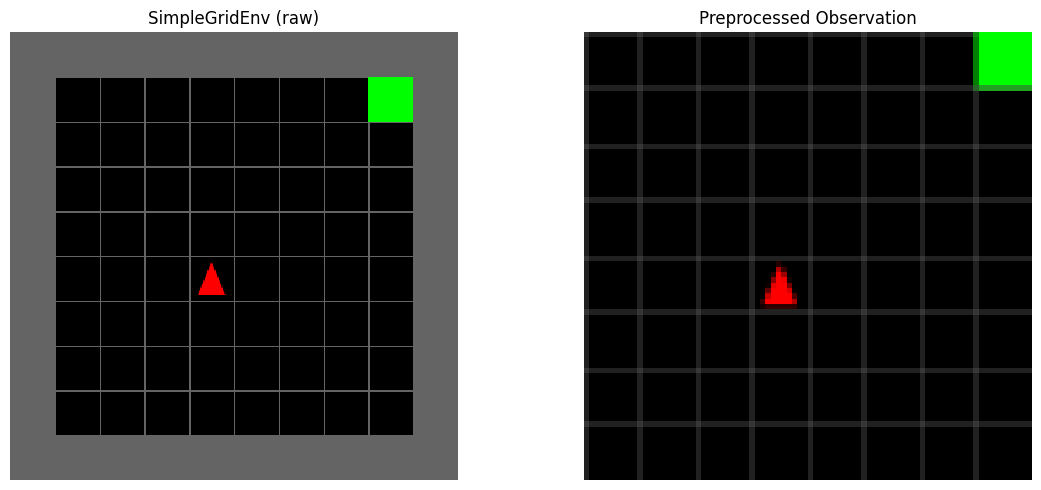

In [8]:
# Initialize environment with preprocessing
env = SimpleGridEnv(max_steps=100, preprocess=pre_process)
obs = env.reset()[0]

print("=== SimpleGridEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("SimpleGridEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Environment 2: KeyDoorBallEnv (Key-Door-Ball Task)

**Task**: Complete a multi-step objective: Key → Door → Ball → Goal

| Property | Value |
|----------|-------|
| Grid Size | 8×8 (two rooms) |
| Partition Wall | Column 3 |
| Key Location | Left room (random) |
| Door Location | In partition wall (random row) |
| Ball Location | Right room (random) |
| Goal Position | Fixed at (8, 8) |
| Actions | 0: Left, 1: Right, 2: Forward, 3: Pickup, 4: Toggle |

**Sequence**: Pick up key → Open door → Enter right room → Pick up ball → Reach goal

**Helper Methods** (use in reward shaping):
- `is_carrying_key()` — True if agent has the key
- `is_carrying_ball()` — True if agent has the ball
- `is_door_open()` — True if door is open

### Quick Test

=== KeyDoorBallEnv ===
Action space:       Discrete(5)
Number of actions:  5
Observation space:  Box(0, 255, (84, 84, 3), uint8)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 3)
Agent direction:    0
Agent position:     (1, 1)
Goal position:      (8, 8)
Carrying key:       False
Door open:          False
Carrying ball:      False


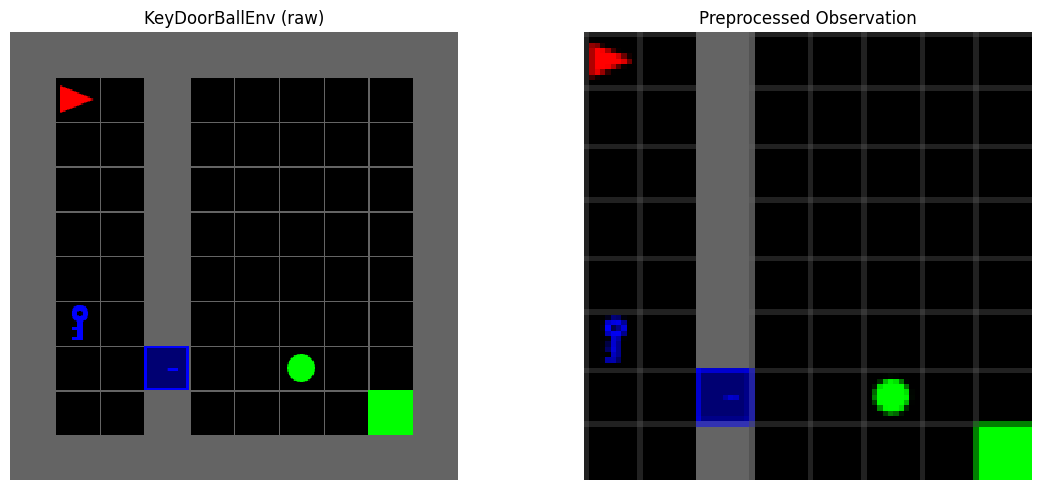

In [9]:
# Initialize environment
env = KeyDoorBallEnv(max_steps=5000, preprocess=pre_process)
obs = env.reset()[0]

print("=== KeyDoorBallEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")
print(f"Carrying key:       {env.is_carrying_key()}")
print(f"Door open:          {env.is_door_open()}")
print(f"Carrying ball:      {env.is_carrying_ball()}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("KeyDoorBallEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [10]:
# COLAB ONLY — restore before submission (/content/ path doesn't exist on macOS)
# # Random action rollout + video
# max_steps = 100
# env = KeyDoorBallEnv(max_steps=max_steps, preprocess=pre_process)
# num_actions = env.action_space.n
# obs = env.reset()[0]
# video_filename = "/content/KeyDoorBallEnv_random.mp4"
#
# with imageio.get_writer(video_filename, fps=10) as video:
#     obs, _ = env.reset()
#     done = False
#     total_reward = 0
#     for step in range(max_steps):
#         action = random.randint(0, num_actions - 1)
#         obs, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
#         total_reward += reward
#         video.append_data(env.render())
#         if done:
#             break
#
# # Print episode summary
# print("=== Episode Summary ===")
# print(f"Steps:         {step + 1}")
# print(f"Total reward:  {total_reward:.3f}")
# print(f"Terminated:    {terminated}")
# print(f"Truncated:     {truncated}")
# print()
# print("=== Environment Status (End of Episode) ===")
# print(f"Agent position:  {env.agent_pos}")
# print(f"Carrying key:    {env.is_carrying_key()}")
# print(f"Door open:       {env.is_door_open()}")
# print(f"Carrying ball:   {env.is_carrying_ball()}")
#
# embed_mp4(video_filename)

# 1. Networks

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def obs_to_tensor(obs, device):
    """
    Convert a preprocessed numpy observation to a batched tensor in (N, C, H, W) format.
    Normalises uint8 pixels from [0, 255] to [0, 1] — critical for CNN convergence
    (Kaiming-initialised weights assume ~unit-variance inputs).

    Args:
        obs: numpy array of shape (H, W, C), e.g. (84, 84, 3), dtype uint8
        device: torch device

    Returns:
        Tensor of shape (1, C, H, W) on the given device, values in [0, 1]
    """
    # (H, W, C) -> (C, H, W), convert to float32 and normalise to [0, 1]
    t = torch.from_numpy(obs.transpose(2, 0, 1).astype(np.float32, copy=False))
    t = t.mul_(1.0 / 255.0)  # in-place: [0,255] -> [0,1]
    return t.unsqueeze(0).to(device)


class CNNFeatureExtractor(nn.Module):
    """
    CNN for extracting features from preprocessed grid-world images.

    Uses small 3×3 kernels with stride 2 to capture fine spatial detail
    (agent triangle, goal square) in the sparse 84×84 grayscale images.
    Inputs are expected in [0, 1] (via obs_to_tensor normalisation).

    Input:  (batch, 3, 84, 84)  — channels-first RGB, values in [0, 1]
    Output: (batch, feature_dim)

    Architecture:
        Conv1 + ReLU: 32 × 3×3, stride 2, pad 1 → 42×42
        Conv2 + ReLU: 64 × 3×3, stride 2, pad 1 → 21×21
        Conv3 + ReLU: 64 × 3×3, stride 2, pad 1 → 11×11
        Conv4 + ReLU: 64 × 3×3, stride 2, pad 1 →  6×6
        Flatten → 2304
        FC + ReLU → feature_dim
    """

    def __init__(self, input_channels=3, feature_dim=256):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2, padding=1)

        # 64 * 6 * 6 = 2304  (84 → 42 → 21 → 11 → 6)
        self.fc = nn.Linear(64 * 6 * 6, feature_dim)
        self.feature_dim = feature_dim

    def forward(self, x):
        """
        Args:
            x: Float tensor of shape (batch, C, H, W).

        Returns:
            Feature vector of shape (batch, feature_dim)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x


class ActorCriticNetwork(nn.Module):
    """
    Actor-Critic network with a shared CNN backbone and two heads:
        - Actor  (policy head): outputs action logits
        - Critic (value head):  outputs scalar state value V(s)

    Sharing the backbone means the CNN learns features useful for both
    action selection and value estimation, which is more sample-efficient.

    Input:  (batch, 3, 84, 84)
    Output: logits (batch, num_actions), value (batch, 1)
    """

    def __init__(self, num_actions, feature_dim=256):
        super().__init__()

        self.cnn = CNNFeatureExtractor(input_channels=3, feature_dim=feature_dim)
        self.policy_head = nn.Linear(feature_dim, num_actions)
        self.value_head = nn.Linear(feature_dim, 1)

    def forward(self, x):
        """
        Returns:
            logits: (batch, num_actions) — raw unnormalised action scores
            value:  (batch, 1) — estimated state value V(s)
        """
        features = self.cnn(x)
        logits = self.policy_head(features)
        value = self.value_head(features)
        return logits, value

    def act(self, obs, device):
        """
        Select an action for a single observation (keeps grad for training).

        Returns:
            action: int
            log_prob: scalar tensor shape () (with grad)
            entropy: scalar tensor shape ()
            value: scalar tensor shape () (with grad)
        """
        obs_t = obs_to_tensor(obs, device)
        logits, value = self.forward(obs_t)

        # squeeze(0) removes the batch dim so Categorical has batch_shape ()
        # → log_prob, entropy, sample all return true scalars (shape ())
        dist = torch.distributions.Categorical(logits=logits.squeeze(0))
        action = dist.sample()

        return (
            action.item(),
            dist.log_prob(action),   # shape ()
            dist.entropy(),          # shape ()
            value.squeeze(),         # (1,1) -> scalar ()
        )

    @torch.no_grad()
    def get_value(self, obs, device):
        """Get V(s) for a single observation (no grad, for bootstrapping)."""
        obs_t = obs_to_tensor(obs, device)
        _, value = self.forward(obs_t)
        return value.squeeze().item()

# 2. A2C Algorithm

In [12]:
import torch.optim as optim


def train_actor_critic(
    env_class,
    num_episodes=10000,
    max_steps=200,
    lr=0.0007,
    gamma=0.99,
    entropy_coef=0.01,
    value_coef=0.5,
    n_steps=5,
    max_grad_norm=0.5,
    print_every=100,
    device=None,
    tile_size=10,
):
    """
    Train an Advantage Actor-Critic (A2C) agent.

    Uses n-step returns for advantage estimation:
        A_t = (Σ_{k=0}^{n-1} γ^k r_{t+k}) + γ^n V(s_{t+n}) - V(s_t)

    Args:
        env_class: Environment class (SimpleGridEnv or KeyDoorBallEnv)
        num_episodes: Total training episodes
        max_steps: Max steps per episode
        lr: Learning rate for Adam
        gamma: Discount factor
        entropy_coef: Entropy bonus weight (exploration)
        value_coef: Critic loss weight (relative to actor loss)
        n_steps: Number of steps for n-step returns
        max_grad_norm: Gradient clipping norm
        print_every: Logging frequency
        device: torch device
        tile_size: Tile size for env rendering (smaller = faster)

    Returns:
        agent: TrainedActorCriticAgent wrapper
        history: dict with episode_rewards, episode_steps, avg_entropy,
                 actor_losses, critic_losses
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- environment & network ----
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
    num_actions = env.action_space.n

    model = ActorCriticNetwork(num_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # ---- bookkeeping ----
    history = {
        "episode_rewards": [],
        "episode_steps": [],
        "running_reward": 0.0,
        "avg_entropy": [],
        "actor_losses": [],
        "critic_losses": [],
    }

    print(f"Training A2C on {env_class.__name__}")
    print(f"Episodes: {num_episodes}, Max steps: {max_steps}, n_steps: {n_steps}")
    print(f"LR: {lr}, Gamma: {gamma}, Entropy coef: {entropy_coef}")
    print("=" * 60)

    update_count = 0

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0.0

        # n-step buffers (collected within the episode, flushed every n_steps)
        step_log_probs = []
        step_values = []
        step_rewards = []
        step_entropies = []

        for step in range(max_steps):
            action, log_prob, entropy, value = model.act(obs, device)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            step_log_probs.append(log_prob)
            step_values.append(value)
            step_rewards.append(reward)
            step_entropies.append(entropy)

            done = terminated or truncated

            # ---- update every n_steps or at episode end ----
            if len(step_rewards) == n_steps or done:
                # Bootstrap value for non-terminal states
                if done:
                    R = 0.0
                else:
                    R = model.get_value(next_obs, device)

                # Compute n-step returns (backward through buffer)
                returns = []
                for r in reversed(step_rewards):
                    R = r + gamma * R
                    returns.append(R)
                returns.reverse()

                returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
                log_probs_t = torch.stack(step_log_probs)
                values_t = torch.stack(step_values).squeeze(-1)
                entropies_t = torch.stack(step_entropies)

                # Advantage = returns - V(s)  (no grad through returns)
                advantages = returns_t - values_t.detach()
                # Normalise so actor gradient isn't dwarfed by entropy term
                if advantages.numel() > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Losses
                actor_loss = -(log_probs_t * advantages).mean()
                critic_loss = (returns_t.detach() - values_t).pow(2).mean()
                entropy_bonus = entropies_t.mean()

                loss = actor_loss + value_coef * critic_loss - entropy_coef * entropy_bonus

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

                update_count += 1
                history["actor_losses"].append(actor_loss.item())
                history["critic_losses"].append(critic_loss.item())
                history["avg_entropy"].append(entropy_bonus.item())

                # Clear buffers
                step_log_probs = []
                step_values = []
                step_rewards = []
                step_entropies = []

            obs = next_obs
            if done:
                break

        # ---- record episode stats ----
        history["episode_rewards"].append(episode_reward)
        history["episode_steps"].append(step + 1)

        if history["running_reward"] == 0.0:
            history["running_reward"] = episode_reward
        else:
            history["running_reward"] = (
                0.95 * history["running_reward"] + 0.05 * episode_reward
            )

        # ---- logging ----
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(history["episode_rewards"][-print_every:])
            avg_steps = np.mean(history["episode_steps"][-print_every:])
            recent_entropy = (
                np.mean(history["avg_entropy"][-50:])
                if history["avg_entropy"] else 0.0
            )
            print(
                f"Episode {episode + 1:5d} | "
                f"Avg Reward: {avg_reward:8.3f} | "
                f"Avg Steps: {avg_steps:6.1f} | "
                f"Entropy: {recent_entropy:.3f} | "
                f"Running: {history['running_reward']:8.3f}"
            )

    print("=" * 60)
    print("Training complete!")
    recent = min(print_every, len(history["episode_rewards"]))
    print(
        f"Last {recent} episodes — "
        f"Avg Reward: {np.mean(history['episode_rewards'][-recent:]):.3f}, "
        f"Avg Steps: {np.mean(history['episode_steps'][-recent:]):.1f}"
    )

    env.close()
    agent = TrainedActorCriticAgent(model, device)
    return agent, history


class TrainedActorCriticAgent:
    """
    Wrapper around a trained ActorCriticNetwork for evaluation.

    Usage:
        action = agent.select_action(obs)          # greedy (argmax)
        action = agent.select_action(obs, greedy=False)  # stochastic
    """

    def __init__(self, model, device):
        self.model = model
        self.device = device

    @torch.no_grad()
    def select_action(self, obs, greedy=True):
        obs_t = obs_to_tensor(obs, self.device)
        logits, _ = self.model(obs_t)

        if greedy:
            return logits.argmax(dim=-1).item()
        else:
            dist = torch.distributions.Categorical(logits=logits)
            return dist.sample().item()

# 3. Utils

In [13]:
import os


# ---------------------------------------------------------------------------
# Plotting
# ---------------------------------------------------------------------------

def plot_training_history(history, title="Training History", save_path=None):
    """
    Plot reward and step curves from a training history dict.

    Expects *history* to contain at least:
        - episode_rewards : list[float]
        - episode_steps   : list[int]

    Optionally plots entropy if history contains:
        - avg_entropy : list[float]

    Args:
        history: dict returned by a training function
        title: plot super-title
        save_path: if provided, save the figure to this path instead of plt.show()
    """
    has_entropy = "avg_entropy" in history and len(history["avg_entropy"]) > 0
    ncols = 3 if has_entropy else 2
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 4))

    window = min(100, max(1, len(history["episode_rewards"]) // 10))

    # ---- rewards ----
    ax = axes[0]
    ax.plot(history["episode_rewards"], alpha=0.3, label="Per episode")
    if len(history["episode_rewards"]) >= window:
        smoothed = np.convolve(
            history["episode_rewards"],
            np.ones(window) / window,
            mode="valid",
        )
        ax.plot(
            range(window - 1, len(history["episode_rewards"])),
            smoothed,
            label=f"{window}-ep avg",
        )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title(f"{title} — Rewards")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ---- steps ----
    ax = axes[1]
    ax.plot(history["episode_steps"], alpha=0.3, label="Per episode")
    if len(history["episode_steps"]) >= window:
        smoothed = np.convolve(
            history["episode_steps"],
            np.ones(window) / window,
            mode="valid",
        )
        ax.plot(
            range(window - 1, len(history["episode_steps"])),
            smoothed,
            label=f"{window}-ep avg",
        )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Steps")
    ax.set_title(f"{title} — Steps per Episode")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ---- entropy (optional) ----
    if has_entropy:
        ax = axes[2]
        ax.plot(history["avg_entropy"])
        ax.set_xlabel("Update step")
        ax.set_ylabel("Entropy")
        ax.set_title(f"{title} — Policy Entropy")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved training plot to: {save_path}")
        plt.close()
    else:
        plt.show()


# ---------------------------------------------------------------------------
# Evaluation
# ---------------------------------------------------------------------------

def evaluate_agent(agent, env_class, num_episodes=100, max_steps=200,
                   tile_size=10):
    """
    Evaluate a trained agent over multiple episodes.

    The agent must expose ``select_action(obs) -> int``.

    Args:
        agent: trained agent (or None for random baseline)
        env_class: environment class (SimpleGridEnv / KeyDoorBallEnv)
        num_episodes: number of evaluation episodes
        max_steps: max steps per episode
        tile_size: tile size for rendering (smaller = faster)

    Returns:
        dict with keys: num_episodes, avg_reward, std_reward, avg_steps,
        std_steps, success_rate, min_steps, max_steps, all_rewards, all_steps
    """
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)

    episode_rewards = []
    episode_steps = []
    successes = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0.0

        for step in range(max_steps):
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.select_action(obs)

            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            if terminated:
                successes += 1
                break
            if truncated:
                break

        episode_rewards.append(total_reward)
        episode_steps.append(step + 1)

        # Progress bar
        done = ep + 1
        pct = done / num_episodes
        bar_len = 30
        filled = int(bar_len * pct)
        bar = "█" * filled + "░" * (bar_len - filled)
        print(
            f"\rEvaluating: |{bar}| {done}/{num_episodes} "
            f"({pct*100:.0f}%) success so far: {successes}/{done}",
            end="",
            flush=True,
        )

    print()  # newline after progress bar
    env.close()

    return {
        "num_episodes": num_episodes,
        "avg_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "avg_steps": np.mean(episode_steps),
        "std_steps": np.std(episode_steps),
        "success_rate": successes / num_episodes,
        "min_steps": int(np.min(episode_steps)),
        "max_steps": int(np.max(episode_steps)),
        "all_rewards": episode_rewards,
        "all_steps": episode_steps,
    }


def print_evaluation_results(results, title="Evaluation Results"):
    """Print formatted evaluation metrics."""
    print("=" * 60)
    print(f" {title}")
    print("=" * 60)
    print(f"  Episodes evaluated:  {results['num_episodes']}")
    print(f"  Success rate:        {results['success_rate']*100:.1f}%")
    print("-" * 60)
    print(f"  Average reward:      {results['avg_reward']:.3f} +/- {results['std_reward']:.3f}")
    print(f"  Average steps:       {results['avg_steps']:.1f} +/- {results['std_steps']:.1f}")
    print(f"  Step range:          [{results['min_steps']}, {results['max_steps']}]")
    print("=" * 60)


# ---------------------------------------------------------------------------
# Video recording
# ---------------------------------------------------------------------------

def record_video(agent, env_class, filename, num_episodes=1, max_steps=200,
                  fps=10):
    """
    Record an agent playing and save as GIF.

    Args:
        agent: trained agent with select_action(obs), or None for random
        env_class: environment class
        filename: output GIF path (e.g. "outputs/agent.gif")
        num_episodes: episodes to record
        max_steps: max steps per episode
        fps: frames per second for the GIF

    Returns:
        (total_reward, total_steps)
    """
    # Use full tile_size=32 for crisp video frames
    env = env_class(preprocess=pre_process, max_steps=max_steps, tile_size=32)

    frames = []
    total_reward = 0.0
    total_steps = 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        frame = env.render()
        if frame is not None:
            frames.append(np.array(frame))

        for step in range(max_steps):
            if agent is None:
                action = env.action_space.sample()
            else:
                action = agent.select_action(obs)

            obs, reward, terminated, truncated, _ = env.step(action)
            frame = env.render()
            if frame is not None:
                frames.append(np.array(frame))
            total_reward += reward
            total_steps += 1

            if terminated or truncated:
                break

    env.close()

    if not frames:
        print("Warning: no frames captured, skipping video save.")
        return total_reward, total_steps

    # duration in ms per frame (imageio v2.9+ uses duration instead of fps)
    duration_ms = 1000.0 / fps

    out_dir = os.path.dirname(filename)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    imageio.mimsave(filename, frames, duration=duration_ms, loop=0)
    print(f"Video saved: {filename}  ({len(frames)} frames, {fps} fps)")
    print(f"  Episodes: {num_episodes}, Total steps: {total_steps}, Total reward: {total_reward:.2f}")

    return total_reward, total_steps

# 4. SimpleGridEnv Experiment

In [52]:
# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ── A2C hyperparameters ─────────────────────────────────────────────────────
A2C_CONFIG = {
    "num_episodes": 30000,
    "max_steps": 100,          # random agent finds goal ~17 % of the time
    "lr": 0.0003,              # lower LR for stability (A2C is noisy)
    "gamma": 0.95,
    "entropy_coef": 0.02,      # lighter entropy to let policy commit
    "value_coef": 0.5,
    "n_steps": 20,             # longer horizon covers more of the episode
    "max_grad_norm": 0.5,
    "print_every": 500,
    "tile_size": 10,
}

# ── Train ────────────────────────────────────────────────────────────────────
a2c_agent, a2c_history = train_actor_critic(
    env_class=SimpleGridEnv,
    device=device,
    **A2C_CONFIG,
)

# ── Store results (dict keyed by algorithm name — easy to add DQN later) ────
simplegrid_results = {
    "A2C": {"agent": a2c_agent, "history": a2c_history, "config": A2C_CONFIG},
    # "DQN": {"agent": dqn_agent, "history": dqn_history, "config": DQN_CONFIG},  # ← Dor adds this
}

Device: cpu
Training A2C on SimpleGridEnv
Episodes: 30000, Max steps: 100, n_steps: 20
LR: 0.0003, Gamma: 0.95, Entropy coef: 0.02
Episode   500 | Avg Reward:   -0.721 | Avg Steps:   97.5 | Entropy: 0.548 | Running:   -0.952
Episode  1000 | Avg Reward:   -0.965 | Avg Steps:   99.7 | Entropy: 0.759 | Running:   -0.997
Episode  1500 | Avg Reward:   -0.974 | Avg Steps:   99.8 | Entropy: 0.562 | Running:   -0.988
Episode  2000 | Avg Reward:   -0.840 | Avg Steps:   98.7 | Entropy: 0.813 | Running:   -0.328
Episode  2500 | Avg Reward:   -0.734 | Avg Steps:   97.8 | Entropy: 0.813 | Running:   -0.568
Episode  3000 | Avg Reward:   -0.398 | Avg Steps:   92.9 | Entropy: 0.658 | Running:    0.142
Episode  3500 | Avg Reward:   -0.367 | Avg Steps:   92.7 | Entropy: 0.653 | Running:   -0.673
Episode  4000 | Avg Reward:    0.365 | Avg Steps:   84.9 | Entropy: 0.533 | Running:    0.913
Episode  4500 | Avg Reward:    0.771 | Avg Steps:   77.7 | Entropy: 0.476 | Running:    0.128
Episode  5000 | Avg Rew

## Training Curves

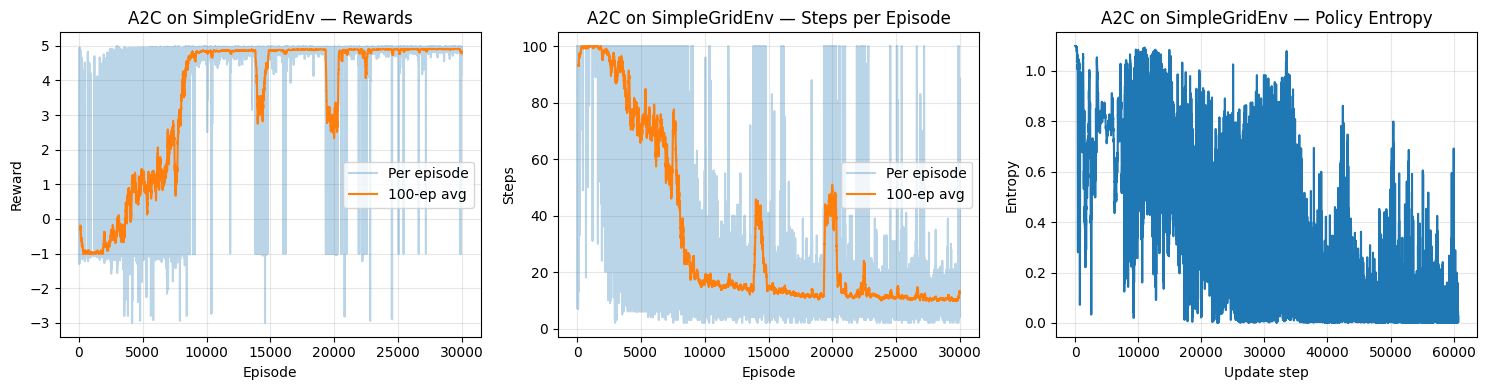

In [53]:
# ── Individual training curves per algorithm ─────────────────────────────────
for algo_name, data in simplegrid_results.items():
    plot_training_history(data["history"], title=f"{algo_name} on SimpleGridEnv")

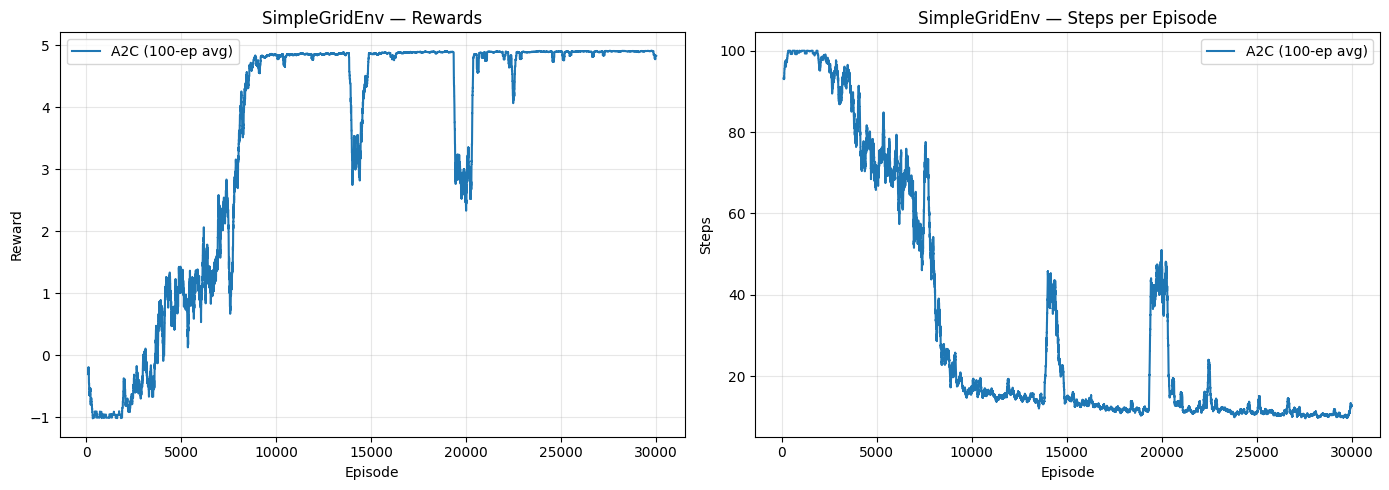

In [54]:
# ── Comparison overlay (rewards + steps) ─────────────────────────────────────
# Overlays all algorithms in simplegrid_results on the same axes.
# Currently only A2C; when DQN is added to the dict, it appears automatically.

SMOOTHING_WINDOW = 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for algo_name, data in simplegrid_results.items():
    rewards = data["history"]["episode_rewards"]
    steps   = data["history"]["episode_steps"]

    # smoothed rewards
    if len(rewards) >= SMOOTHING_WINDOW:
        kernel = np.ones(SMOOTHING_WINDOW) / SMOOTHING_WINDOW
        sm_rewards = np.convolve(rewards, kernel, mode="valid")
        sm_steps   = np.convolve(steps,   kernel, mode="valid")
        x = range(SMOOTHING_WINDOW - 1, len(rewards))
        axes[0].plot(x, sm_rewards, label=f"{algo_name} ({SMOOTHING_WINDOW}-ep avg)")
        axes[1].plot(x, sm_steps,   label=f"{algo_name} ({SMOOTHING_WINDOW}-ep avg)")
    else:
        axes[0].plot(rewards, label=algo_name)
        axes[1].plot(steps,   label=algo_name)

axes[0].set_xlabel("Episode"); axes[0].set_ylabel("Reward")
axes[0].set_title("SimpleGridEnv — Rewards"); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel("Episode"); axes[1].set_ylabel("Steps")
axes[1].set_title("SimpleGridEnv — Steps per Episode"); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluation (last 100 episodes)

In [55]:
for algo_name, data in simplegrid_results.items():
    results = evaluate_agent(
        agent=data["agent"],
        env_class=SimpleGridEnv,
        num_episodes=100,
        max_steps=data["config"]["max_steps"],
    )
    print_evaluation_results(results, title=f"{algo_name} on SimpleGridEnv — Evaluation")
    data["eval"] = results  # store for later comparison
    print()

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 100/100
 A2C on SimpleGridEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        100.0%
------------------------------------------------------------
  Average reward:      4.908 +/- 0.029
  Average steps:       10.2 +/- 2.9
  Step range:          [4, 17]



## Video — Trained Agent

In [56]:
# Records a GIF of the trained agent (works on macOS — no Xvfb needed)
for algo_name, data in simplegrid_results.items():
    gif_path = f"simplegrid_{algo_name.lower()}_trained.gif"
    record_video(
        agent=data["agent"],
        env_class=SimpleGridEnv,
        filename=gif_path,
        num_episodes=1,
        max_steps=data["config"]["max_steps"],
    )

Video saved: simplegrid_a2c_trained.gif  (4 frames, 10 fps)
  Episodes: 1, Total steps: 3, Total reward: 4.98


# DQN Algorithm (Dor)

This section implements **Deep Q-Network (DQN)** with:
- **Experience Replay** — decorrelates sequential transitions
- **Target Network** — stabilises TD targets via periodic hard copies
- **ε-greedy exploration** — linear decay from 1.0 → ε_end
- **Smart Reward Shaping** — phase-aware dense rewards for KeyDoorBallEnv
- **Weight Initialisation experiments** — Xavier, Kaiming, Default

The CNN feature extractor (`CNNFeatureExtractor`) and preprocessing
(`pre_process`, `obs_to_tensor`) are Sara's shared code defined above.

## Replay Buffer

In [14]:
# =====================================================================
# CELL 41 — Replay Buffer (numpy-backed, faster sampling)
# =====================================================================
import collections


class ReplayBuffer:
    """
    Fixed-size circular replay buffer storing (s, a, r, s', done) tuples.

    Uses a plain list + modular index instead of collections.deque so that
    sampling via np.random.randint (O(batch)) replaces random.sample on a
    deque (which internally copies the whole deque to a list — O(N)).

    Observations are stored as uint8 to save memory (~7 KB per 84×84×3
    transition vs ~28 KB for float32).
    """

    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer: list = []
        self.pos = 0

    def push(self, state: np.ndarray, action: int, reward: float,
             next_state: np.ndarray, done: bool):
        item = (
            np.asarray(state, dtype=np.uint8),
            action,
            reward,
            np.asarray(next_state, dtype=np.uint8),
            done,
        )
        if len(self.buffer) < self.capacity:
            self.buffer.append(item)
        else:
            self.buffer[self.pos] = item
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int, device: torch.device):
        """
        Sample a random mini-batch and return GPU-ready tensors.

        Returns:
            states:      (B, C, H, W) float32 in [0, 1]
            actions:     (B, 1) int64
            rewards:     (B, 1) float32
            next_states: (B, C, H, W) float32 in [0, 1]
            dones:       (B, 1) float32  (1.0 = terminal)
        """
        indices = np.random.randint(0, len(self.buffer), size=batch_size)
        batch = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)

        def to_tensor_batch(obs_list):
            arr = np.stack(obs_list)                       # (B, H, W, C)
            arr = arr.transpose(0, 3, 1, 2)                # (B, C, H, W)
            t = torch.from_numpy(arr.astype(np.float32))
            t.mul_(1.0 / 255.0)
            return t.to(device)

        return (
            to_tensor_batch(states),
            torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1),
            torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1),
            to_tensor_batch(next_states),
            torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1),
        )

    def __len__(self):
        return len(self.buffer)

## DQN Network

The Q-network reuses Sara's `CNNFeatureExtractor` as the vision backbone,
feeding its 256-dim feature vector into an FC head that outputs one Q-value
per action.

A separate **target network** is a full copy whose weights are hard-updated
every `target_update_freq` optimisation steps. This decouples the moving
prediction from the TD target, preventing oscillation.

In [15]:
# =====================================================================
# CELL 43 — DQN Network + Agent (no structural changes, just cleaner)
# =====================================================================
class DQN_Network(nn.Module):
    """
    Q-Network = CNNFeatureExtractor + FC head → Q(s, a).

    Architecture after CNN backbone:
        features (256) → FC(256, 128) → ReLU → FC(128, num_actions)
    """

    def __init__(self, num_actions: int, feature_dim: int = 256):
        super().__init__()
        self.cnn = CNNFeatureExtractor(input_channels=3, feature_dim=feature_dim)
        self.fc1 = nn.Linear(feature_dim, 128)
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        x = F.relu(self.fc1(features))
        return self.fc2(x)


class DQNAgent:
    """
    DQN agent with epsilon-greedy exploration and target network.

    Design choices:
    - Linear epsilon decay (not exponential): predictable exploration budget.
    - Hard target update (not Polyak/soft): simpler, effective for small envs.
    - Huber loss (smooth_l1): robust to large TD errors from reward shaping.
    """

    def __init__(
        self,
        num_actions: int,
        device: torch.device,
        lr: float = 5e-4,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay_episodes: int = 1000,
        target_update_freq: int = 1000,
        feature_dim: int = 256,
    ):
        self.num_actions = num_actions
        self.device = device
        self.gamma = gamma
        self.target_update_freq = target_update_freq

        # Epsilon schedule
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_episodes = epsilon_decay_episodes

        # Networks
        self.q_net = DQN_Network(num_actions, feature_dim).to(device)
        self.target_net = DQN_Network(num_actions, feature_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.optimise_step = 0

    def select_action(self, obs: np.ndarray, greedy: bool = False) -> int:
        """Epsilon-greedy action selection."""
        if not greedy and random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)

        with torch.no_grad():
            state_t = obs_to_tensor(obs, self.device)
            q_values = self.q_net(state_t)
            return q_values.argmax(dim=1).item()

    def decay_epsilon(self, episode: int):
        """Linear epsilon decay."""
        frac = min(1.0, episode / max(1, self.epsilon_decay_episodes))
        self.epsilon = self.epsilon_start + frac * (self.epsilon_end - self.epsilon_start)

    def optimise(self, replay_buffer: ReplayBuffer, batch_size: int) -> float:
        """
        One gradient step of DQN with Huber loss.
        Returns loss value for logging.
        """
        states, actions, rewards, next_states, dones = replay_buffer.sample(
            batch_size, self.device
        )

        # Current Q-values for chosen actions
        q_values = self.q_net(states).gather(1, actions)

        # Target: r + gamma * max Q_target(s', .) * (1 - done)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(dim=1, keepdim=True)[0]
            target = rewards + self.gamma * next_q * (1.0 - dones)

        loss = F.smooth_l1_loss(q_values, target)

        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), max_norm=1.0)
        self.optimizer.step()

        # Hard target update
        self.optimise_step += 1
        if self.optimise_step % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()



## Smart Reward Shaping Wrapper (KeyDoorBallEnv)

The agent's observation remains **pixel-based** (84×84×3 RGB).
The wrapper only uses the environment's internal state to compute a
dense reward signal — the agent never sees these coordinates.

### Phase Logic
| Phase | Condition to enter | Sub-goal | Dense signal |
|-------|--------------------|----------|-------------|
| 0 | Start | Get key | ↓ Manhattan distance to key |
| 1 | Key picked up | Open door | ↓ distance to door |
| 2 | Door opened | Get ball | ↓ distance to ball |
| 3 | Ball picked up | Reach goal | ↓ distance to goal |

**Design rationale:**
- Manhattan distance matches the grid movement model.
- Distance delta reward (+0.1 closer, −0.1 further) is potential-based,
  preserving optimal policy (Ng et al., 1999).
- Milestone bonuses (+0.5) dominate step penalties so the agent always
  prefers completing sub-goals over looping.

In [16]:
# =====================================================================
# CELL 45 — SmartRewardWrapper (REWRITE — much stronger shaping)
# =====================================================================
class SmartRewardWrapper(gym.Wrapper):
    """
    Phase-aware reward shaping for KeyDoorBallEnv.

    Changes vs. previous version:
    ─────────────────────────────────────────────────────────────
    PROBLEM → FIX
    ─────────────────────────────────────────────────────────────
    Distance ±0.1 too weak for noisy pixel obs
        → Increased to ±0.3

    Milestones +0.5 too small vs step penalties
        → Key +2.0, Door +3.0, Ball +2.0 (scaled to task difficulty)

    No signal for using pickup/toggle near target
        → "Proximity bonus": +0.05 when adjacent to phase target
          and facing it — teaches the agent that being AT the
          target in the right orientation is valuable

    Step penalty -0.01 makes timeout = -3.0 (same as any episode)
        → Increased to -0.02 so timeout = -6.0, clearly worse
          than partial progress episodes (-2 to -4)

    Goal +5.0 was ok but now milestones are bigger
        → Goal +10.0 to keep it the dominant signal
    ─────────────────────────────────────────────────────────────
    """

    def __init__(self, env):
        super().__init__(env)
        self._prev_dist = None
        self._phase = 0

    def _manhattan(self, a, b) -> int:
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def _get_target_pos(self):
        uw = self.env.unwrapped
        if self._phase == 0:
            return uw.key_pos
        elif self._phase == 1:
            return uw.door_pos
        elif self._phase == 2:
            return uw.ball_pos
        else:
            return uw.goal_pos

    def _update_phase(self):
        """Advance phase and return milestone bonus (if any)."""
        uw = self.env.unwrapped
        bonus = 0.0
        if self._phase == 0 and uw.is_carrying_key():
            self._phase = 1
            bonus = 2.0       # was 0.5
        if self._phase == 1 and uw.is_door_open():
            self._phase = 2
            bonus += 3.0      # was 0.5 — door is hardest milestone
        if self._phase == 2 and uw.is_carrying_ball():
            self._phase = 3
            bonus += 2.0      # was 0.5
        return bonus

    def _facing_target(self) -> bool:
        """Check if agent's front_pos matches the current phase target."""
        uw = self.env.unwrapped
        target = self._get_target_pos()
        front = uw.front_pos
        return (front[0] == target[0] and front[1] == target[1])

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self._phase = 0
        self._prev_dist = self._manhattan(
            self.env.unwrapped.agent_pos, self._get_target_pos()
        )
        return obs, info

    def step(self, action):
        pos_before = tuple(self.env.unwrapped.agent_pos)

        obs, _orig_reward, terminated, truncated, info = self.env.step(action)

        # Phase transitions
        milestone_bonus = self._update_phase()

        # Terminal — big reward so it dominates everything
        if terminated:
            return obs, 10.0 + milestone_bonus, terminated, truncated, info

        # Dense distance signal (stronger: ±0.3 instead of ±0.1)
        target = self._get_target_pos()
        cur_dist = self._manhattan(self.env.unwrapped.agent_pos, target)
        dist_delta = 0.0
        if self._prev_dist is not None:
            dist_delta = 0.3 * (self._prev_dist - cur_dist)
        self._prev_dist = cur_dist

        # Proximity bonus: reward being adjacent + facing the target
        # This bridges the gap between "near the key" and "pressing pickup"
        proximity = 0.05 if self._facing_target() else 0.0

        # Wall bump
        wall_bump = -0.03 if (action == 2 and tuple(self.env.unwrapped.agent_pos) == pos_before) else 0.0

        # Step penalty: -0.02 so timeout(300) = -6.0, clearly worse than partial progress
        shaped = -0.02 + dist_delta + milestone_bonus + proximity + wall_bump
        return obs, shaped, terminated, truncated, info

## Weight Initialisation Helper

Three strategies tested:
- **Xavier Uniform** — preserves variance assuming linear activations
- **Kaiming Uniform (He)** — designed for ReLU networks
- **Default (PyTorch)** — built-in init

**Hypothesis:** Kaiming should converge fastest since all activations use ReLU.

In [17]:
def apply_weight_init(model: nn.Module, init_type: str = "kaiming") -> nn.Module:
    """
    Re-initialise all Conv2d and Linear layers.

    Args:
        model: nn.Module
        init_type: "xavier", "kaiming", or "default"
    Returns:
        Same model (modified in-place).
    """
    if init_type == "default":
        return model

    def _init_fn(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    model.apply(_init_fn)
    return model

## DQN Training Loop

**Key details:**
- Training starts only after `min_replay_size` transitions (random exploration
  fills the buffer with diverse experiences first).
- ε decays **per episode** (not per step) — intuitive to tune.
- Accepts either an env class or a pre-wrapped instance (for SmartRewardWrapper).

In [18]:
# =====================================================================
# CELL 49 — DQN Training Loop (Double DQN + train_every)
# =====================================================================
def train_dqn(
    env_or_class,
    num_episodes: int = 5000,
    max_steps: int = 300,
    lr: float = 3e-4,
    gamma: float = 0.99,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.02,
    epsilon_decay_episodes: int = 2500,
    batch_size: int = 128,
    replay_capacity: int = 100_000,
    min_replay_size: int = 2000,
    target_update_freq: int = 1000,
    train_every: int = 4,
    double_dqn: bool = True,       # ★ NEW — Double DQN
    init_type: str = "kaiming",
    print_every: int = 100,
    device: torch.device = None,
    tile_size: int = 10,
):
    """
    Full DQN training loop with optional Double DQN.

    Double DQN fix: vanilla DQN uses the target network for BOTH action
    selection and evaluation in the TD target, which causes systematic
    overestimation.  Double DQN uses the ONLINE network to select the
    best action, then the TARGET network to evaluate it:

        Vanilla:  target = r + γ * max_a Q_target(s', a)
        Double:   a* = argmax_a Q_online(s', a)
                  target = r + γ * Q_target(s', a*)

    This is a one-line change that consistently improves stability.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Environment
    if isinstance(env_or_class, type):
        env = env_or_class(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
    else:
        env = env_or_class

    num_actions = env.action_space.n

    # Agent
    agent = DQNAgent(
        num_actions=num_actions, device=device, lr=lr, gamma=gamma,
        epsilon_start=epsilon_start, epsilon_end=epsilon_end,
        epsilon_decay_episodes=epsilon_decay_episodes,
        target_update_freq=target_update_freq,
    )
    apply_weight_init(agent.q_net, init_type)
    agent.target_net.load_state_dict(agent.q_net.state_dict())
    agent.target_net.eval()

    # ★ Patch the optimise method if Double DQN is enabled
    if double_dqn:
        _original_optimise = agent.optimise

        def _double_dqn_optimise(replay_buffer, batch_size):
            states, actions, rewards, next_states, dones = replay_buffer.sample(
                batch_size, agent.device
            )
            q_values = agent.q_net(states).gather(1, actions)

            with torch.no_grad():
                # ★ Double DQN: online net selects action, target net evaluates
                best_actions = agent.q_net(next_states).argmax(dim=1, keepdim=True)
                next_q = agent.target_net(next_states).gather(1, best_actions)
                target = rewards + agent.gamma * next_q * (1.0 - dones)

            loss = F.smooth_l1_loss(q_values, target)

            agent.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.q_net.parameters(), max_norm=1.0)
            agent.optimizer.step()

            agent.optimise_step += 1
            if agent.optimise_step % agent.target_update_freq == 0:
                agent.target_net.load_state_dict(agent.q_net.state_dict())

            return loss.item()

        agent.optimise = _double_dqn_optimise

    # Replay Buffer
    replay_buffer = ReplayBuffer(replay_capacity)

    # Logging
    history = {
        "episode_rewards": [], "episode_steps": [], "losses": [],
        "epsilons": [], "first_solved_episode": None,
    }

    total_steps = 0

    env_name = type(env.unwrapped).__name__ if hasattr(env, 'unwrapped') else type(env).__name__
    print(f"Training {'Double ' if double_dqn else ''}DQN on {env_name}")
    print(f"Episodes: {num_episodes}, Max steps: {max_steps}, LR: {lr}, Gamma: {gamma}")
    print(f"Batch: {batch_size}, Replay: {replay_capacity}, "
          f"eps: {epsilon_start}->{epsilon_end} over {epsilon_decay_episodes} eps")
    print(f"Target update: {target_update_freq} steps, Train every: {train_every} steps, "
          f"Init: {init_type}, Device: {device}")
    print("=" * 60)

    for episode in range(num_episodes):
        obs, _ = env.reset()
        ep_reward = 0.0
        ep_losses = []

        for step in range(max_steps):
            action = agent.select_action(obs)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.push(obs, action, reward, next_obs, done)
            ep_reward += reward
            obs = next_obs
            total_steps += 1

            # Train every N env steps
            if len(replay_buffer) >= min_replay_size and total_steps % train_every == 0:
                loss = agent.optimise(replay_buffer, batch_size)
                ep_losses.append(loss)

            if done:
                break

        agent.decay_epsilon(episode)
        history["episode_rewards"].append(ep_reward)
        history["episode_steps"].append(step + 1)
        history["epsilons"].append(agent.epsilon)
        history["losses"].append(np.mean(ep_losses) if ep_losses else 0.0)

        if terminated and history["first_solved_episode"] is None:
            history["first_solved_episode"] = episode
            print(f"  *** First solve at episode {episode} "
                  f"(steps={step+1}, reward={ep_reward:.2f}) ***")

        if (episode + 1) % print_every == 0:
            r = np.mean(history["episode_rewards"][-print_every:])
            s = np.mean(history["episode_steps"][-print_every:])
            l = np.mean(history["losses"][-print_every:])
            # Also show solve rate in last 100 eps
            recent_solves = sum(
                1 for i in range(max(0, len(history["episode_steps"]) - print_every),
                                 len(history["episode_steps"]))
                if history["episode_steps"][i] < max_steps
            )
            print(f"Ep {episode+1:5d} | Avg R: {r:8.3f} | Avg S: {s:6.1f} | "
                  f"Loss: {l:.4f} | eps: {agent.epsilon:.3f} | "
                  f"Solves: {recent_solves}/{print_every}")

    print("=" * 60)
    print("Training complete!")
    n = min(print_every, len(history["episode_rewards"]))
    print(f"Last {n} eps — Avg R: {np.mean(history['episode_rewards'][-n:]):.3f}, "
          f"Avg S: {np.mean(history['episode_steps'][-n:]):.1f}")
    if history["first_solved_episode"] is not None:
        print(f"First solved at episode: {history['first_solved_episode']}")

    env.close()
    return agent, history

## DQN Plotting Utility

In [19]:
def plot_dqn_training(history, title="DQN Training", save_path=None):
    """Plot DQN training curves: rewards, steps, loss, epsilon."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    window = min(100, max(1, len(history["episode_rewards"]) // 10))
    kernel = np.ones(window) / window if window > 0 else None

    def _smooth_plot(ax, data, color, ylabel, subtitle):
        ax.plot(data, alpha=0.2, color=color)
        if kernel is not None and len(data) >= window:
            sm = np.convolve(data, kernel, mode="valid")
            ax.plot(range(window-1, len(data)), sm, color=color, label=f"{window}-ep avg")
            ax.legend()
        ax.set_xlabel("Episode"); ax.set_ylabel(ylabel)
        ax.set_title(f"{title} — {subtitle}"); ax.grid(True, alpha=0.3)

    _smooth_plot(axes[0,0], history["episode_rewards"], "tab:blue", "Reward", "Rewards")
    _smooth_plot(axes[0,1], history["episode_steps"], "tab:orange", "Steps", "Steps/Episode")
    _smooth_plot(axes[1,0], history.get("losses",[]), "tab:red", "Loss", "Huber Loss")

    ax = axes[1,1]
    ax.plot(history.get("epsilons",[]), color="tab:green")
    ax.set_xlabel("Episode"); ax.set_ylabel("epsilon")
    ax.set_title(f"{title} — Epsilon Schedule"); ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.close()
    else:
        plt.show()


def evaluate_dqn(agent, env_maker, num_episodes=100, max_steps=500):
    """Evaluate DQN agent on a wrapped environment."""
    env = env_maker(max_steps=max_steps)
    ep_rewards, ep_steps, successes = [], [], 0

    for ep in range(num_episodes):
        obs, _ = env.reset()
        total_r = 0.0
        for step in range(max_steps):
            action = agent.select_action(obs, greedy=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_r += reward
            if terminated:
                successes += 1; break
            if truncated:
                break
        ep_rewards.append(total_r)
        ep_steps.append(step + 1)
        pct = (ep+1) / num_episodes
        bar = "█" * int(30*pct) + "░" * (30 - int(30*pct))
        print(f"\rEval: |{bar}| {ep+1}/{num_episodes} success: {successes}/{ep+1}", end="", flush=True)

    print()
    env.close()
    return {
        "num_episodes": num_episodes,
        "avg_reward": np.mean(ep_rewards), "std_reward": np.std(ep_rewards),
        "avg_steps": np.mean(ep_steps), "std_steps": np.std(ep_steps),
        "success_rate": successes / num_episodes,
        "min_steps": int(np.min(ep_steps)), "max_steps": int(np.max(ep_steps)),
        "all_rewards": ep_rewards, "all_steps": ep_steps,
    }

# 5. KeyDoorBallEnv Experiment (DQN — Dor)

### Primary Training Run
Using the best expected hyperparameters with Kaiming initialisation
and smart reward shaping.

In [20]:
# =====================================================================
# CELL 53 — KeyDoorBallEnv Training Config (tuned for the hard task)
# =====================================================================
# -- Reproducibility --
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

torch.backends.cudnn.benchmark = True

# -- Environment factory --
def make_keydoor_env(max_steps=300, tile_size=10):
    base_env = KeyDoorBallEnv(preprocess=pre_process, max_steps=max_steps, tile_size=tile_size)
    return SmartRewardWrapper(base_env)

# -- DQN config --
# ┌──────────────────────────────────────────────────────────────────┐
# │ CHANGE LOG vs previous config:                                    │
# │                                                                    │
# │ epsilon_decay: 800 → 2500                                         │
# │   WHY: 800 was the #1 killer. The agent committed to a bad        │
# │   policy before it had ANY successful trajectories to learn from. │
# │   A 4-step sequential task from pixels needs MUCH more random     │
# │   exploration to stumble onto key→door→ball→goal by chance.       │
# │                                                                    │
# │ epsilon_end: 0.01 → 0.02                                          │
# │   WHY: Keep a tiny bit more exploration even after convergence.   │
# │   With 5 actions, 2% randomness barely hurts exploitation but     │
# │   prevents complete lock-in to a suboptimal deterministic policy. │
# │                                                                    │
# │ num_episodes: 3000 → 5000                                         │
# │   WHY: More exploration time means more episodes needed overall.  │
# │   But each episode is faster (max_steps=300 + train_every=4).    │
# │                                                                    │
# │ lr: 5e-4 → 3e-4                                                   │
# │   WHY: Slightly lower for stability. The stronger reward shaping  │
# │   means bigger TD errors; a smaller LR prevents oscillation.      │
# │                                                                    │
# │ replay_capacity: 50K → 100K                                       │
# │   WHY: More episodes = more transitions. We want successful       │
# │   trajectories to persist in the buffer longer, not get           │
# │   overwritten by 50K timeout transitions.                         │
# │                                                                    │
# │ min_replay_size: 1000 → 2000                                      │
# │   WHY: More diverse initial data before the first gradient step.  │
# │   With ε=1.0 and 5 actions, 2000 random transitions give better  │
# │   coverage of the state space.                                     │
# │                                                                    │
# │ double_dqn: NEW → True                                            │
# │   WHY: Vanilla DQN systematically overestimates Q-values, which   │
# │   is especially damaging with strong reward shaping (the agent    │
# │   overestimates the value of states near milestones). Double DQN  │
# │   decouples action selection from evaluation — free stability.    │
# └──────────────────────────────────────────────────────────────────┘
DQN_KEYDOOR_CONFIG = {
    "num_episodes": 5000,
    "max_steps": 300,
    "lr": 3e-4,                       # was 5e-4
    "gamma": 0.99,
    "epsilon_start": 1.0,
    "epsilon_end": 0.02,              # was 0.01
    "epsilon_decay_episodes": 2500,   # was 800 — THIS IS THE BIG ONE
    "batch_size": 128,
    "replay_capacity": 100_000,       # was 50K
    "min_replay_size": 2000,          # was 1000
    "target_update_freq": 1000,
    "train_every": 4,
    "double_dqn": True,               # ★ NEW
    "init_type": "kaiming",
    "print_every": 100,
    "tile_size": 10,
}

# -- Train --
keydoor_env = make_keydoor_env(
    max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
    tile_size=DQN_KEYDOOR_CONFIG["tile_size"],
)
dqn_keydoor_agent, dqn_keydoor_history = train_dqn(
    env_or_class=keydoor_env,
    device=device,
    **{k: v for k, v in DQN_KEYDOOR_CONFIG.items() if k != "tile_size"},
)


Device: cuda
Training Double DQN on KeyDoorBallEnv
Episodes: 5000, Max steps: 300, LR: 0.0003, Gamma: 0.99
Batch: 128, Replay: 100000, eps: 1.0->0.02 over 2500 eps
Target update: 1000 steps, Train every: 4 steps, Init: kaiming, Device: cuda
Ep   100 | Avg R:   -4.197 | Avg S:  300.0 | Loss: 0.0058 | eps: 0.961 | Solves: 0/100
Ep   200 | Avg R:   -2.959 | Avg S:  300.0 | Loss: 0.0089 | eps: 0.922 | Solves: 0/100
  *** First solve at episode 262 (steps=226, reward=14.08) ***
Ep   300 | Avg R:   -1.992 | Avg S:  299.1 | Loss: 0.0112 | eps: 0.883 | Solves: 2/100
Ep   400 | Avg R:   -0.991 | Avg S:  297.0 | Loss: 0.0124 | eps: 0.844 | Solves: 5/100
Ep   500 | Avg R:    0.003 | Avg S:  293.7 | Loss: 0.0191 | eps: 0.804 | Solves: 8/100
Ep   600 | Avg R:    2.229 | Avg S:  278.8 | Loss: 0.0259 | eps: 0.765 | Solves: 21/100
Ep   700 | Avg R:    3.350 | Avg S:  270.8 | Loss: 0.0341 | eps: 0.726 | Solves: 27/100
Ep   800 | Avg R:    7.216 | Avg S:  250.0 | Loss: 0.0390 | eps: 0.687 | Solves: 50/1

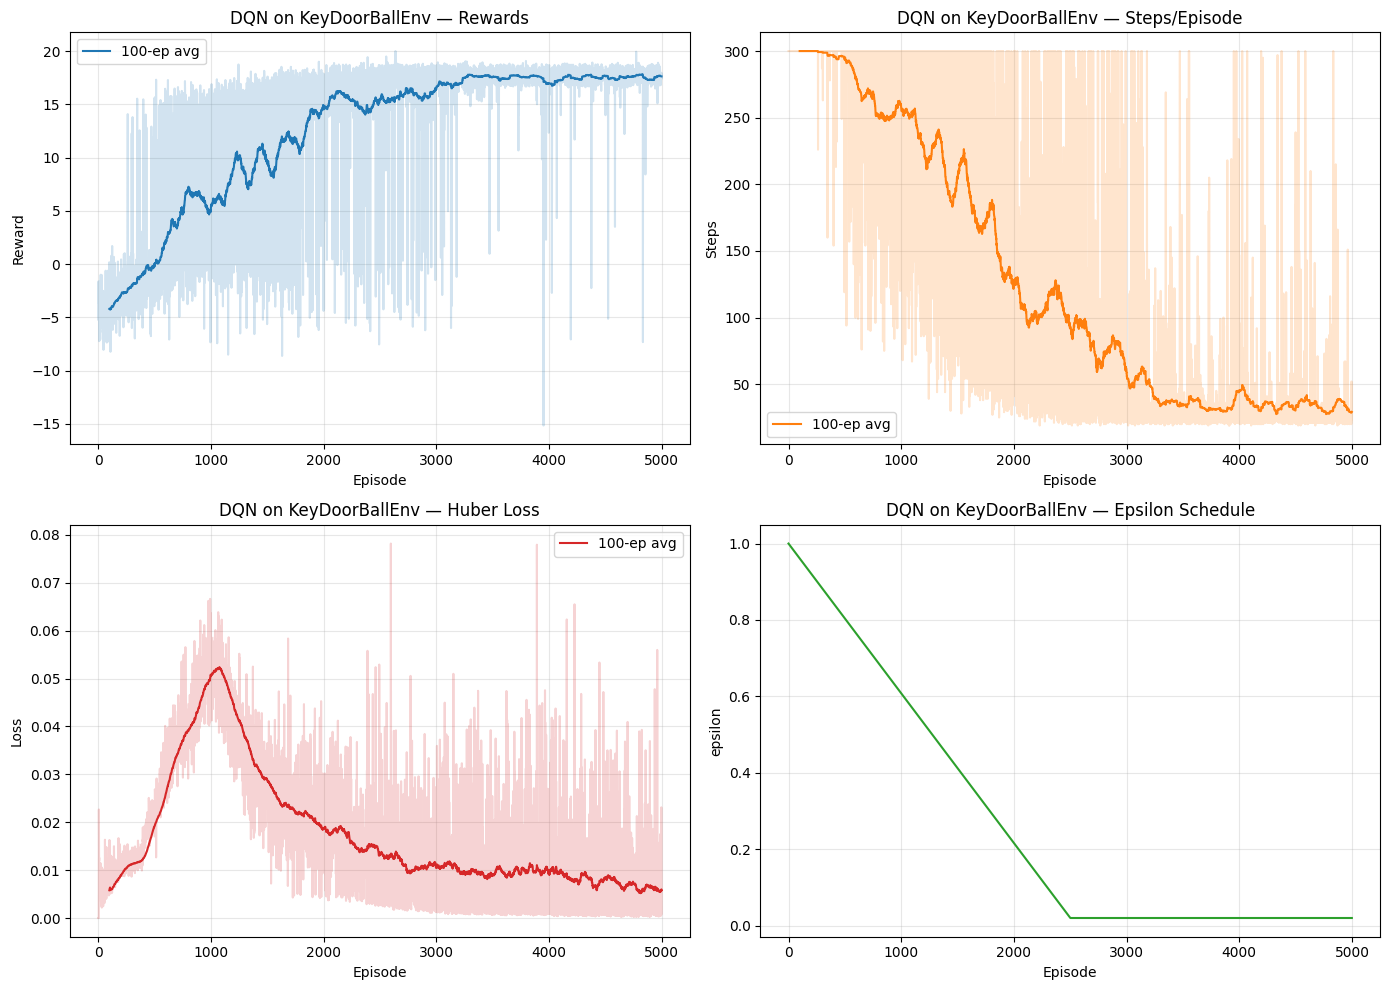

In [21]:
# Training curves
plot_dqn_training(dqn_keydoor_history, title="DQN on KeyDoorBallEnv")

In [22]:
# Evaluation (last 100 episodes)
dqn_keydoor_eval = evaluate_dqn(
    dqn_keydoor_agent, make_keydoor_env,
    num_episodes=100, max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
)
print_evaluation_results(dqn_keydoor_eval, title="DQN on KeyDoorBallEnv — Evaluation")

Eval: |██████████████████████████████| 100/100 success: 90/100
 DQN on KeyDoorBallEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        90.0%
------------------------------------------------------------
  Average reward:      16.068 +/- 5.382
  Average steps:       54.0 +/- 82.1
  Step range:          [20, 300]


In [23]:
# Video — converged agent
record_video(
    agent=dqn_keydoor_agent, env_class=KeyDoorBallEnv,
    filename="keydoor_dqn_trained.gif", num_episodes=1,
    max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
)

Video saved: keydoor_dqn_trained.gif  (29 frames, 10 fps)
  Episodes: 1, Total steps: 28, Total reward: 1.00


(1.0, 28)

## Weight Initialisation Experiment (KeyDoorBallEnv)

Training DQN with identical hyperparameters under three init schemes.
Reduced episodes (1500) to keep runtime manageable while showing convergence trends.


  Weight Init: xavier
Training Double DQN on KeyDoorBallEnv
Episodes: 1500, Max steps: 300, LR: 0.0003, Gamma: 0.99
Batch: 128, Replay: 100000, eps: 1.0->0.02 over 1500 eps
Target update: 1000 steps, Train every: 4 steps, Init: xavier, Device: cuda
  *** First solve at episode 110 (steps=162, reward=14.87) ***
Ep   500 | Avg R:    0.247 | Avg S:  287.1 | Loss: 0.0182 | eps: 0.674 | Solves: 68/500
Ep  1000 | Avg R:    7.450 | Avg S:  240.7 | Loss: 0.0472 | eps: 0.347 | Solves: 245/500
Ep  1500 | Avg R:    8.837 | Avg S:  213.1 | Loss: 0.0290 | eps: 0.021 | Solves: 290/500
Training complete!
Last 500 eps — Avg R: 8.837, Avg S: 213.1
First solved at episode: 110

  Weight Init: kaiming
Training Double DQN on KeyDoorBallEnv
Episodes: 1500, Max steps: 300, LR: 0.0003, Gamma: 0.99
Batch: 128, Replay: 100000, eps: 1.0->0.02 over 1500 eps
Target update: 1000 steps, Train every: 4 steps, Init: kaiming, Device: cuda
  *** First solve at episode 116 (steps=251, reward=13.68) ***
Ep   500 | Avg R

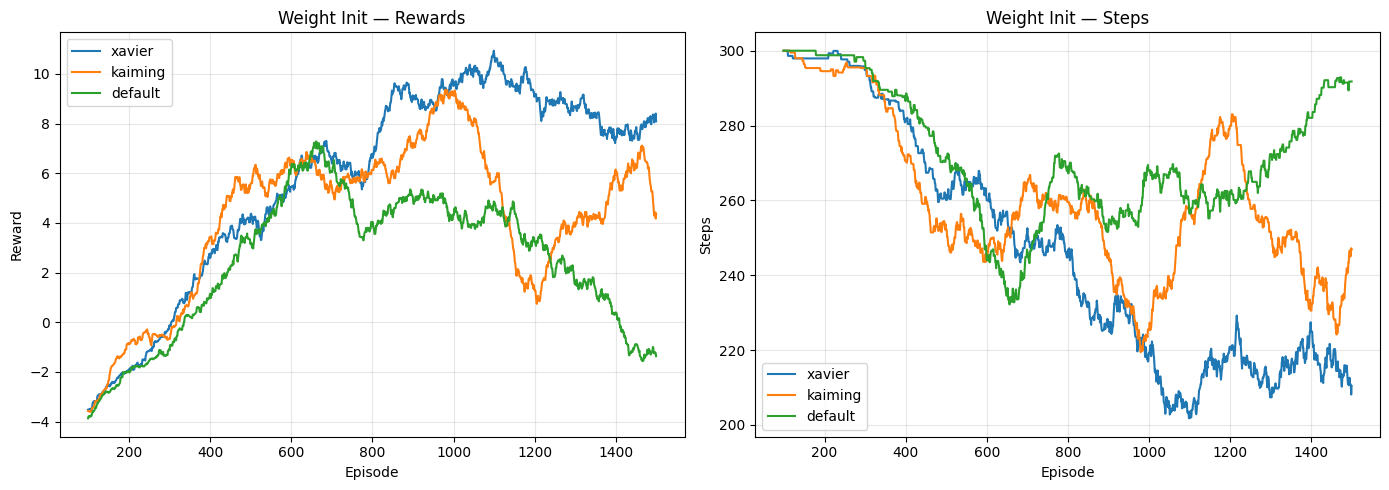


Weight Init Results (KeyDoorBallEnv)
Init        1st Solved  Last-100 R  Last-100 S
---------------------------------------------
xavier             110       8.086       210.4
kaiming            116       4.373       246.9
default            179      -1.364       291.8


In [24]:
# =====================================================================
# CELL 58 — Weight Init Experiment (updated to use new params)
# =====================================================================
INIT_EXPERIMENT_EPS = 1500
init_results = {}

for init_name in ["xavier", "kaiming", "default"]:
    print(f"\n{'='*60}\n  Weight Init: {init_name}\n{'='*60}")
    set_seed(SEED)
    exp_env = make_keydoor_env(
        max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
        tile_size=DQN_KEYDOOR_CONFIG["tile_size"],
    )
    _, hist = train_dqn(
        env_or_class=exp_env,
        num_episodes=INIT_EXPERIMENT_EPS,
        max_steps=DQN_KEYDOOR_CONFIG["max_steps"],
        lr=DQN_KEYDOOR_CONFIG["lr"],
        gamma=DQN_KEYDOOR_CONFIG["gamma"],
        epsilon_start=DQN_KEYDOOR_CONFIG["epsilon_start"],
        epsilon_end=DQN_KEYDOOR_CONFIG["epsilon_end"],
        epsilon_decay_episodes=min(DQN_KEYDOOR_CONFIG["epsilon_decay_episodes"], INIT_EXPERIMENT_EPS),
        batch_size=DQN_KEYDOOR_CONFIG["batch_size"],
        replay_capacity=DQN_KEYDOOR_CONFIG["replay_capacity"],
        min_replay_size=DQN_KEYDOOR_CONFIG["min_replay_size"],
        target_update_freq=DQN_KEYDOOR_CONFIG["target_update_freq"],
        train_every=DQN_KEYDOOR_CONFIG["train_every"],  # ★ pass train_every
        init_type=init_name,
        print_every=500,
        device=device,
    )
    init_results[init_name] = hist

# -- Overlay plot --
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
SM = 100
for name, h in init_results.items():
    r, s = h["episode_rewards"], h["episode_steps"]
    if len(r) >= SM:
        k = np.ones(SM)/SM
        x = range(SM-1, len(r))
        axes[0].plot(x, np.convolve(r, k, "valid"), label=name)
        axes[1].plot(x, np.convolve(s, k, "valid"), label=name)

axes[0].set_xlabel("Episode"); axes[0].set_ylabel("Reward")
axes[0].set_title("Weight Init — Rewards"); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xlabel("Episode"); axes[1].set_ylabel("Steps")
axes[1].set_title("Weight Init — Steps"); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Summary table
print("\nWeight Init Results (KeyDoorBallEnv)")
print(f"{'Init':<10} {'1st Solved':>11} {'Last-100 R':>11} {'Last-100 S':>11}")
print("-" * 45)
for name, h in init_results.items():
    print(f"{name:<10} {str(h.get('first_solved_episode','N/A')):>11} "
          f"{np.mean(h['episode_rewards'][-100:]):>11.3f} "
          f"{np.mean(h['episode_steps'][-100:]):>11.1f}")



# 6. DQN on SimpleGridEnv (Comparison Data for Sara)

Running DQN on SimpleGridEnv so Sara can produce the A2C vs DQN overlay graphs.

Training Double DQN on SimpleGridEnv
Episodes: 5000, Max steps: 100, LR: 0.0005, Gamma: 0.95
Batch: 128, Replay: 30000, eps: 1.0->0.01 over 1500 eps
Target update: 500 steps, Train every: 4 steps, Init: kaiming, Device: cuda
  *** First solve at episode 7 (steps=40, reward=4.59) ***
Ep   500 | Avg R:    2.050 | Avg S:   69.6 | Loss: 0.0375 | eps: 0.671 | Solves: 282/500
Ep  1000 | Avg R:    4.775 | Avg S:   22.2 | Loss: 0.0141 | eps: 0.341 | Solves: 500/500
Ep  1500 | Avg R:    4.890 | Avg S:   11.8 | Loss: 0.0067 | eps: 0.011 | Solves: 500/500
Ep  2000 | Avg R:    4.917 | Avg S:    9.3 | Loss: 0.0036 | eps: 0.010 | Solves: 500/500
Ep  2500 | Avg R:    4.919 | Avg S:    9.1 | Loss: 0.0011 | eps: 0.010 | Solves: 500/500
Ep  3000 | Avg R:    4.918 | Avg S:    9.2 | Loss: 0.0002 | eps: 0.010 | Solves: 500/500
Ep  3500 | Avg R:    4.918 | Avg S:    9.2 | Loss: 0.0001 | eps: 0.010 | Solves: 500/500
Ep  4000 | Avg R:    4.919 | Avg S:    9.1 | Loss: 0.0001 | eps: 0.010 | Solves: 500/500
Ep  

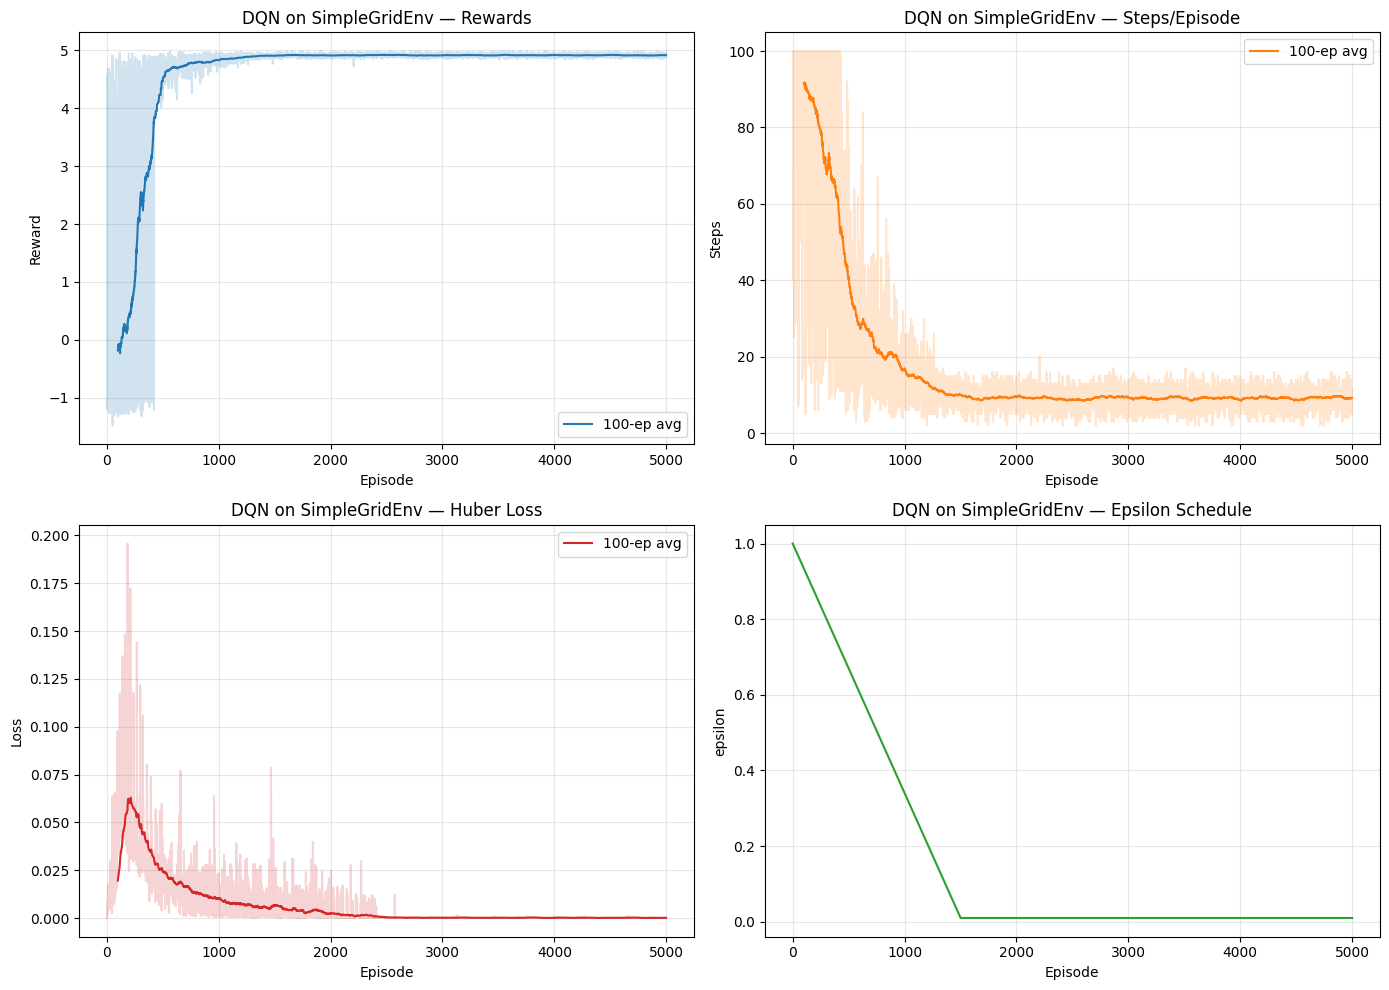

Evaluating: |██████████████████████████████| 100/100 (100%) success so far: 100/100
 DQN on SimpleGridEnv — Evaluation
  Episodes evaluated:  100
  Success rate:        100.0%
------------------------------------------------------------
  Average reward:      4.918 +/- 0.027
  Average steps:       9.2 +/- 2.7
  Step range:          [2, 17]


In [25]:
# =====================================================================
# CELL 60 — DQN on SimpleGridEnv (updated config)
# =====================================================================
set_seed(SEED)

DQN_SIMPLE_CONFIG = {
    "num_episodes": 5000,
    "max_steps": 100,
    "lr": 5e-4,
    "gamma": 0.95,
    "epsilon_start": 1.0,
    "epsilon_end": 0.01,
    "epsilon_decay_episodes": 1500,    # was 2000
    "batch_size": 128,                 # was 64
    "replay_capacity": 30_000,
    "min_replay_size": 500,
    "target_update_freq": 500,         # was 300 — more stable
    "train_every": 4,                  # ★ NEW
    "init_type": "kaiming",
    "print_every": 500,
    "tile_size": 10,
}

dqn_simple_agent, dqn_simple_history = train_dqn(
    env_or_class=SimpleGridEnv,
    device=device,
    **DQN_SIMPLE_CONFIG,
)

plot_dqn_training(dqn_simple_history, title="DQN on SimpleGridEnv")

dqn_simple_eval = evaluate_agent(
    agent=dqn_simple_agent, env_class=SimpleGridEnv,
    num_episodes=100, max_steps=DQN_SIMPLE_CONFIG["max_steps"],
)
print_evaluation_results(dqn_simple_eval, title="DQN on SimpleGridEnv — Evaluation")

# Store for Sara's comparison
simplegrid_results = simplegrid_results if 'simplegrid_results' in dir() else {}
simplegrid_results["DQN"] = {
    "agent": dqn_simple_agent, "history": dqn_simple_history,
    "config": DQN_SIMPLE_CONFIG, "eval": dqn_simple_eval,
}

In [26]:
record_video(
    agent=dqn_simple_agent, env_class=SimpleGridEnv,
    filename="simplegrid_dqn_trained.gif", num_episodes=1,
    max_steps=DQN_SIMPLE_CONFIG["max_steps"],
)

Video saved: simplegrid_dqn_trained.gif  (5 frames, 10 fps)
  Episodes: 1, Total steps: 4, Total reward: 4.97


(4.97, 4)

## Updated Comparison: A2C vs DQN on SimpleGridEnv

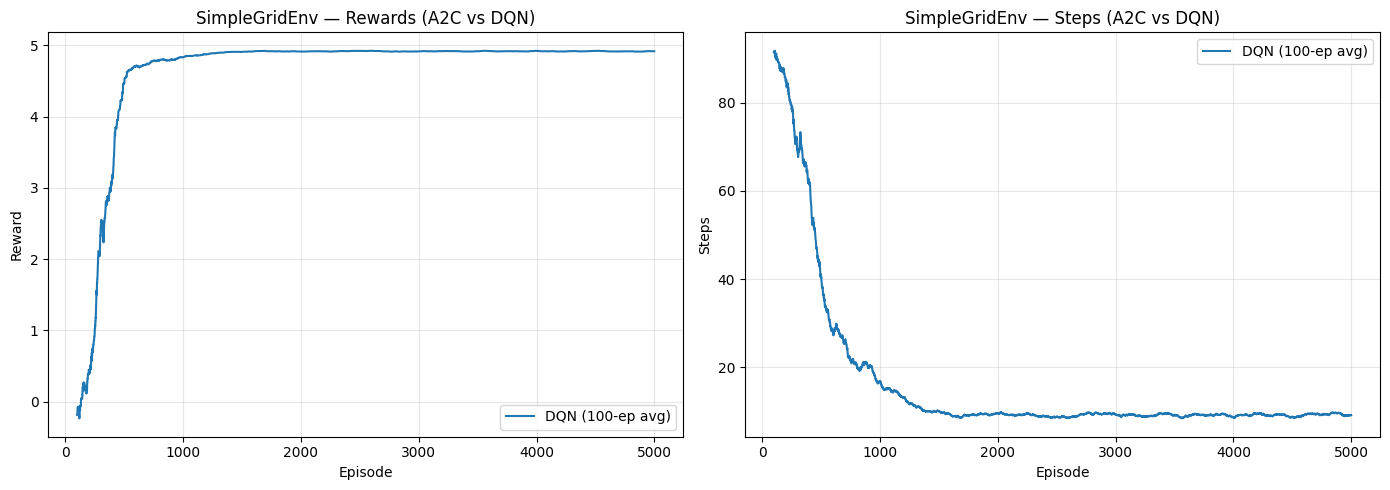


SimpleGridEnv — Last 100 Episodes
Algo        Avg R    Avg S   Success
-----------------------------------
DQN         4.918      9.2    100.0%


In [27]:
SMOOTHING_WINDOW = 100
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for algo, data in simplegrid_results.items():
    r = data["history"]["episode_rewards"]
    s = data["history"]["episode_steps"]
    if len(r) >= SMOOTHING_WINDOW:
        k = np.ones(SMOOTHING_WINDOW) / SMOOTHING_WINDOW
        x = range(SMOOTHING_WINDOW - 1, len(r))
        axes[0].plot(x, np.convolve(r, k, "valid"), label=f"{algo} ({SMOOTHING_WINDOW}-ep avg)")
        axes[1].plot(x, np.convolve(s, k, "valid"), label=f"{algo} ({SMOOTHING_WINDOW}-ep avg)")
    else:
        axes[0].plot(r, label=algo)
        axes[1].plot(s, label=algo)

axes[0].set_xlabel("Episode"); axes[0].set_ylabel("Reward")
axes[0].set_title("SimpleGridEnv — Rewards (A2C vs DQN)")
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xlabel("Episode"); axes[1].set_ylabel("Steps")
axes[1].set_title("SimpleGridEnv — Steps (A2C vs DQN)")
axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print("\nSimpleGridEnv — Last 100 Episodes")
print(f"{'Algo':<8} {'Avg R':>8} {'Avg S':>8} {'Success':>9}")
print("-" * 35)
for algo, data in simplegrid_results.items():
    if "eval" in data:
        e = data["eval"]
        print(f"{algo:<8} {e['avg_reward']:>8.3f} {e['avg_steps']:>8.1f} {e['success_rate']*100:>8.1f}%")